 # Проект: вариант 4

# Задание 1

**Условия:** представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

**Данные:**
- active_users – информация о пользователях, которые посещали приложение во время эксперимента. 
- groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
- purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

Для анализов результатов эксперимента, учитывая имеющиеся данные, были выбраны следующие **метрики:**
- показатели дохода, такие как **средний чек** (в данном случае, средний чек = ARPPU), **ARPU** (конверсия * ARPPU), чтобы увидеть повлияло ли изменение на выручку 
- **конверсия в покупку (CR)**, чтобы посмотреть повлияло ли изменение на частоту покупок

In [140]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats import proportion as proportion, power as smp
from scipy.stats import norm, mannwhitneyu, shapiro
import matplotlib.pyplot as plt

## Данные

In [138]:
df_groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_4_groups.csv')

In [135]:
df_active_users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_4_active_users.csv')

In [134]:
df_purchases = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_4_purchases.csv')

In [139]:
df_groups.head(2)

,user_id,group
0,9149,B
1,9150,B


In [6]:
df_groups.shape

(74576, 2)

In [7]:
df_groups.nunique()

user_id    74576
group          2
dtype: int64

In [8]:
df_groups.isna().sum()

user_id    0
group      0
dtype: int64

In [11]:
df_active_users.head(2)

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male


In [10]:
df_active_users.shape

(8341, 4)

In [13]:
df_active_users.nunique()

user_id     8341
country        2
platform       2
sex            2
dtype: int64

In [14]:
df_active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [15]:
df_purchases.head(2)

,user_id,revenue
0,4412,1000.0
1,9000,701.0


In [16]:
df_purchases.shape

(541, 2)

In [17]:
df_purchases.nunique()

user_id    541
revenue     98
dtype: int64

In [18]:
df_purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

Ознакомившись с данными, получены следующие результаты: в датафреймах нет пропущенных значений и дубликатов. В приложении 74576 уникальных пользователей, на период эксперимента в приложении зашли 8341 пользователь, совершили оплату (транзакцию) 541 пользователь.


--------------------------------------

Проверим совпадают ли id пользователей в датафреймах df_groups(все пользователи), df_active_users(активные на период эксперимента пользователи), df_purchases(оплаты во время эксперимента)

In [19]:
# мерджим датафреймы df_groups, df_active_users
df_active_users.merge(df_groups, how='inner', on=['user_id']).shape

(8341, 5)

In [20]:
# мерджим датафреймы df_groups, df_purchases
df_purchases.merge(df_groups, how='inner', on=['user_id']).shape

(541, 3)

In [21]:
# мерджим датафреймы df_purchases, df_active_users
df_active_users.merge(df_purchases, how='inner', on=['user_id']).shape

(392, 5)

Размеры датафреймов после объединения df_groups с df_active_users и df_groups с df_purchases не изменились.

После объединения датафреймов об активных пользователях и оплатах на период эксперимента количество уникальных пользователей сократилось с 541 до 392. Таким образом, нет информации об активности (посещении приложения) у 149 пользователей, но оплаты ими были совершены на момент эксперимента. Можно предположить, что у этих пользователей деньги были списаны автоматически (например, подписка) или была задержка в списании денег. Сохраним пользователей в отдельный датафрейм df_no_active_users:


In [22]:
# мерджим df_active_users, df_purchases
# заменяем пропущенные значения на 0 
# выбираем строки с нулевыми значениями
# удаляем  колонки
df_no_active_users = df_active_users.merge(df_purchases, how='right', on=['user_id'])\
    .fillna(0)\
    .query('sex == 0')\
    .drop(['country', 'platform', 'sex'], axis=1)

In [23]:
# мерджим df_no_active_users, df_groups
df_no_active_users = df_no_active_users.merge(df_groups, how='inner', on=['user_id'])

In [24]:
df_no_active_users.head(2)

,user_id,revenue,group
0,9000,701.0,B
1,9001,700.0,B


Подготовим датафреймы для дальнейшего анализа, объединив активных пользователей, данные о покупках и группах (без учета 149 пользователей, указанных выше):

In [25]:
# мерджим df_active_users, df_groups  и df_active_users, df_purchases
# заменяем пропущенные значения на 0
df_active_users = df_active_users.merge(df_groups, how='inner', on=['user_id'])
df_active_users = df_active_users.merge(df_purchases, how='left', on=['user_id']).fillna(0)

In [26]:
df_purchases_all = df_purchases.merge(df_groups, how='inner', on=['user_id'])

In [27]:
df_purchases = df_active_users.merge(df_purchases, how='inner', on=['user_id'])\
    .drop(['revenue_y'], axis=1)\
    .rename(columns={'revenue_x': 'revenue'})

In [28]:
df_active_users.head(2)

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0.0
1,1735,Sweden,ios,male,B,0.0


In [29]:
df_purchases.head(2)

,user_id,country,platform,sex,group,revenue
0,1202,Sweden,android,male,A,302.0
1,6284,Russia,android,female,B,208.0


In [30]:
df_purchases_all.head(2)

,user_id,revenue,group
0,4412,1000.0,A
1,9000,701.0,B


-------------------------------------------------------------------

Посмотрим на разделение пользователей на тестовую(B) и контрольную(A) группы. Ожидается, что количество пользователей в группах A и B будут равны, и выборки сбалансированы по сегментам (стране, полу, платформе).

In [31]:
df_groups[df_groups['group'] == "A"].shape

(14693, 2)

In [32]:
df_groups[df_groups['group'] == "B"].shape

(59883, 2)

In [33]:
df_active_users[df_active_users['group'] == "A"].shape

(1538, 6)

In [34]:
df_active_users[df_active_users['group'] == "B"].shape

(6803, 6)

В данном случае количество пользователей в тестовой группе больше в ≈4 раза. Проверим сбалансированность выборок:

In [35]:
# объявим функцию для построения диаграмм по группам и сегментам
def viz_segment(df, segments, group):
    # df - датафрейм
    # segments - сегменты (категории) пользователей
    # group - название столбца с группами (A/B)    
    for segment in segments:
        data = df.groupby([group, segment])\
            .agg({'user_id': 'count'}).reset_index()        
        sns.catplot(x=group, y='user_id', hue=segment, 
                    data=data, kind='bar',
                    height=3, aspect=1.5, 
                    palette=['skyblue', 'lightslategray'])

In [36]:
segments = ['country', 'platform', 'sex']

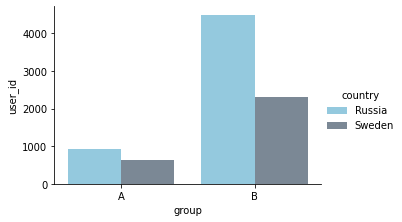

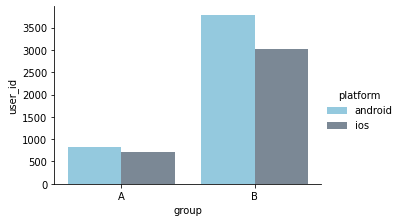

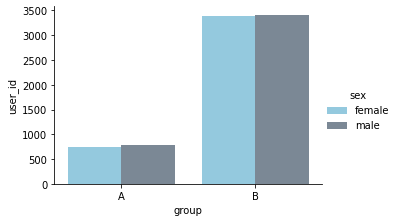

In [37]:
viz_segment(df_active_users, segments, 'group')

Как видно из графиков выше, выборки (из датафрейма df_active_users) несбалансированы по странам и платформам, поэтому результаты эксперимента могут объясняться тем, что нарушена репрезентативность. 

--------------------------------------

Посмотрим на распределение данных, проверим их на нормальность распределения с помощью теста Шапиро и сравним распределения с помощью критерия Манна-Уитни (если распределения отличаются от нормального):

Посмотрим на пользователей, которые не были активны на время эксперимента, но совершили оплаты:

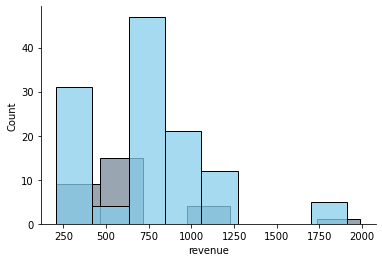

In [38]:
sns.histplot(df_no_active_users[df_no_active_users['group'] == 'A'].revenue, color='lightslategray')
sns.histplot(df_no_active_users[df_no_active_users['group'] == 'B'].revenue, color='skyblue')
sns.despine()

In [126]:
shapiro(df_no_active_users.revenue)

ShapiroResult(statistic=0.8621084094047546, pvalue=1.7290871512365413e-10)

In [40]:
mannwhitneyu(df_no_active_users[df_no_active_users['group'] == 'A'].revenue, df_no_active_users[df_no_active_users['group'] == 'B'].revenue)

MannwhitneyuResult(statistic=1536.5, pvalue=0.32858504025883084)

В результате теста Шапиро, pvalue < 0.05, следовательно, распределение отличается от нормального. 

Непараметрический критерий Манна-Уитни дал значение pvalue = 0.3, что больше 0.05, следовательно, мы не можем отклонить нулевую гипотезу о равенстве распределений. Учитывая равенство распределений, и что пользователи не заходили в приложение, можно предположить, что тестовая группа не видела обновлений, и поэтому в дальнеших расчетах эти данные учитываться не будут. 

Посмотрим на данные о покупках:

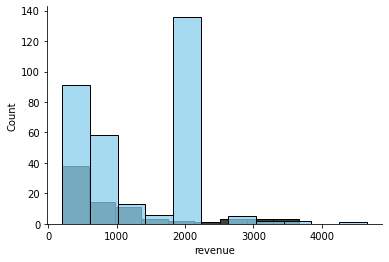

In [41]:
sns.histplot(df_purchases[df_purchases['group'] == 'A'].revenue, color='black')
sns.histplot(df_purchases[df_purchases['group'] == 'B'].revenue, color='skyblue')
sns.despine()

In [42]:
shapiro(df_purchases.revenue)

ShapiroResult(statistic=0.8718748092651367, pvalue=1.768322559841976e-17)

В результате теста, значение pvalue < 0.05, следовательно, распределение отличается от нормального. Проверим распределение данных в тестовой и контрольной группах:
    

In [43]:
shapiro(df_purchases[df_purchases['group'] == 'A'].revenue)

ShapiroResult(statistic=0.7358548641204834, pvalue=1.5417730980793465e-10)

In [44]:
shapiro(df_purchases[df_purchases['group'] == 'B'].revenue)

ShapiroResult(statistic=0.8552882671356201, pvalue=1.665431681028873e-16)

В результате, значение pvalue < 0.05 как в тестовой, так и в контрольной группах, распределение отличается от нормального. 
Проверим гомогенность дисперсий выборок с помощью критерия Левена:

In [45]:
stats.levene(df_purchases[df_purchases['group'] == 'A'].revenue, df_purchases[df_purchases['group'] == 'B'].revenue)

LeveneResult(statistic=3.07680546419023, pvalue=0.08020177652122025)

В результате теста Левена pvalue = 0.08, что больше 0.05, следовательно, мы не можем отклонить нулевую гипотезу о том, что дисперсии равны.

Воспользуемся непараметрическим критерием Манна-Уитни, чтобы сравнить распределение выборок:

In [46]:
mannwhitneyu(df_purchases[df_purchases['group'] == 'A'].revenue, df_purchases[df_purchases['group'] == 'B'].revenue)

MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

В результате, pvalue < 0.05, следовательно, мы можем отклонить нулевую гипотезу о равенстве распределений. 

## Расчет метрик и анализ результатов

### Конверсия в покупку (CR)

***Гипотеза*** - изменение модели оплаты повлияло на конверсию.

Н0 - статистически значимой разницы в конверсии нет

In [47]:
# создадим колонку payment, где 0 - оплаты нет, 1 - оплата есть
df_active_users['payment'] = df_active_users.revenue.apply(lambda x: 0 if x == 0 else 1)

In [48]:
df_active_users.head(2)

,user_id,country,platform,sex,group,revenue,payment
0,8029,Russia,ios,male,B,0.0,0
1,1735,Sweden,ios,male,B,0.0,0


In [49]:
# создаем датафрейм df_CR
# гпуппируя данные по группам, подсчитывая кол-во уникальных пользователей, сумму в колонке payment
df_CR = df_active_users.groupby('group', as_index=False).agg({'user_id': 'count', 'payment': sum})

In [50]:
# рассчитываем CR
df_CR['CR'] = (df_CR.payment / df_CR.user_id).mul(100).round(2)

In [51]:
df_CR

,group,user_id,payment,CR
0,A,1538,78,5.07
1,B,6803,314,4.62


Конверсия в покупку для контрольной группы составила 5.07%, для тестовой - 4.62%. Можно заметить, что конверсия упала на 8%, определим является ли эта разница статистически значимой с помощью теста ХИ-квадрат:

In [52]:
chi2, pvalue, table = proportion.proportions_chisquare(df_CR['payment'], df_CR['user_id'])

In [53]:
pvalue

0.44547028437158964

Таким образом, pvalue = 0.44, что больше 0.05, значит нельзя отклонить гипотезу о том, что статистически значимых различий нет. Рассчитаем мощность ХИ-критерия:

In [54]:
CR_A = df_CR['CR'][0] / 100
CR_B = df_CR['CR'][1] / 100

In [67]:
# рассчитаем effect size
ES = np.sqrt(((CR_A - CR_B) ** 2) / CR_B)

In [68]:
ES

0.020935894733965614

In [69]:
# рассчитаем мощность критерия
smp.GofChisquarePower().solve_power(ES, nobs=min(df_CR['user_id']), alpha=pvalue)

0.5797427318021494

In [70]:
# посчитаем, какое кол-во пользователей необходимо для того, чтобы получить желаемую мощность 0.8
round(smp.GofChisquarePower().solve_power(ES, nobs=None, alpha=0.05, power=0.8) / 2, 0)

8954.0

Мощность теста низкая - 0.58, при норме > 0.8. Это означает, что мало шансов увидеть статистически значимую разницу, если она есть, и в 42 случаев из 100 мы разницу не увидим. Из этого следует, что, возможно, статистически значимая разница между конверсиями есть, но данный тест ее не выявил.
Для увеличения мощности теста необходимо увелить количество пользователей в тестовой и контрольных группах до 8954 пользователей в каждой.  


Посмотрим на конверсию в разбивке по странам:

In [71]:
# расчет конверсии для России
metrics_Russia = df_active_users.query('country == "Russia"')\
    .groupby('group', as_index=False)\
    .agg({'user_id': 'count', 'payment': sum})
metrics_Russia['CR'] = (metrics_Russia.payment / metrics_Russia.user_id).mul(100).round(2)

In [72]:
# расчет конверсии для Швеции
metrics_Sweden = df_active_users.query('country == "Sweden"')\
    .groupby('group', as_index=False)\
    .agg({'user_id': 'count', 'payment': sum})
metrics_Sweden['CR'] = (metrics_Sweden.payment / metrics_Sweden.user_id).mul(100).round(2)

In [73]:
metrics_Russia

,group,user_id,payment,CR
0,A,915,43,4.70
1,B,4492,197,4.39


In [74]:
chi2, pvalue_Ru, table = proportion.proportions_chisquare(metrics_Russia['payment'], metrics_Russia['user_id'])

In [75]:
pvalue_Ru

0.674346253012943

In [76]:
metrics_Sweden

,group,user_id,payment,CR
0,A,623,35,5.62
1,B,2311,117,5.06


In [77]:
chi2, pvalue_Sw, table = proportion.proportions_chisquare(metrics_Sweden['payment'], metrics_Sweden['user_id'])

In [78]:
pvalue_Sw

0.578932365547989

Для обеих стран конверсия снизилась: для России с 4.7% до 4.39% (на 6.59%), для Швеции с 5.62% до 5.06% (на 9.9%). Критерий ХИ-квадрат показал, что в обоих случаях pvalue > 0.05, следовательно, статистически значимой разницы нет.

Аналогично проведем тесты в разбивке по платформам:

In [122]:
# расчет конверсии для ios
metrics_ios = df_active_users.query('platform == "ios"')\
    .groupby('group', as_index=False)\
    .agg({'user_id': 'count', 'payment': sum})
metrics_ios['CR'] = (metrics_ios.payment / metrics_ios.user_id).mul(100).round(2)

In [80]:
# расчет конверсии для android
metrics_android = df_active_users.query('platform == "android"')\
    .groupby('group', as_index=False)\
    .agg({'user_id': 'count', 'payment': sum})
metrics_android['CR'] = (metrics_android.payment / metrics_android.user_id).mul(100).round(2)

In [81]:
metrics_ios

,group,user_id,payment,CR
0,A,704,39,5.54
1,B,3016,145,4.81


In [82]:
chi2, pvalue_ios, table = proportion.proportions_chisquare(metrics_ios['payment'], metrics_ios['user_id'])

In [83]:
pvalue_ios

0.41988733815413914

In [84]:
metrics_android

,group,user_id,payment,CR
0,A,834,39,4.68
1,B,3787,169,4.46


In [85]:
chi2, pvalue_android, table = proportion.proportions_chisquare(metrics_android['payment'], metrics_android['user_id'])


In [86]:
pvalue_android

0.787644893841505

Для обеих платформ конверсия снизилась: для ios с 5.54% до 4.81% (на 13%), для android с 4.68% до 4.46% (на 4.7%). Критерий ХИ-квадрат показал, что в обоих случаях pvalue > 0.05, следовательно, статистически значимой разницы нет.

Проведем тесты в разбивке по полу:

In [87]:
# расчет конверсии для мужчин
metrics_male = df_active_users.query('sex == "male"')\
    .groupby('group', as_index=False)\
    .agg({'user_id': 'count', 'payment': sum})
metrics_male['CR'] = (metrics_male.payment / metrics_male.user_id).mul(100).round(2)

In [120]:
metrics_male

,group,user_id,payment,CR
0,A,785,41,5.22
1,B,3411,160,4.69


In [89]:
chi2, pvalue_male, table = proportion.proportions_chisquare(metrics_male['payment'], metrics_male['user_id'])

In [90]:
pvalue_male

0.528988340798384

In [91]:
# расчет конверсии для женщин
metrics_fem = df_active_users.query('sex == "female"')\
    .groupby('group', as_index=False)\
    .agg({'user_id': 'count', 'payment': sum})
metrics_fem['CR'] = (metrics_fem.payment / metrics_fem.user_id).mul(100).round(2)

In [118]:
metrics_fem

,group,user_id,payment,CR
0,A,753,37,4.91
1,B,3392,154,4.54


In [93]:
chi2, pvalue_fem, table = proportion.proportions_chisquare(metrics_fem['payment'], metrics_fem['user_id'])

In [94]:
pvalue_fem

0.6582542140155113

Для обоих полов конверсия снизилась: для мужчин с 5.22% до 4.69% (на 10%), для женщин с 4.91% до 4.54% (на 7.5%). Критерий ХИ-квадрат показал, что в обоих случаях pvalue > 0.05, следовательно, статистически значимой разницы нет.

**Выводы:** в разбивке по сегментам во всех случаях конверсия снизилась на 4-13%, однако тест ХИ-квадрат не выявил статистически значимой разницы.

### Средний чек 

***Гипотеза*** - изменение модели оплаты повлияло на средний чек (=ARPPU)

H0 - статистически значимых изменений нет

Для сравнения средних используются следующие методы:
- t-тест (критерий Стьюдента)
- bootstrap

При этом, условия для t-теста - нормальность распределения, гомогенность дисперсии (в нашем случае первое условие не соблюдено). Однако, t-тест возможно использовать на ненормальных данных (при больших размерах данных и отсутствии выбросов). Для bootstrap такие условия не требуются.
Для анализа используем оба способа и посмотрим, какие результаты они дадут. В случае если результаты будут отличаться, предпочтение будет отдаваться результатам bootstrap.

Посчитаем средний чек для обеих групп:

In [95]:
df_purchases.head(2)

,user_id,country,platform,sex,group,revenue
0,1202,Sweden,android,male,A,302.0
1,6284,Russia,android,female,B,208.0


In [96]:
avg_check = df_purchases.groupby('group', as_index=False).agg({'revenue': "mean"}).round(2)

In [97]:
avg_check

,group,revenue
0,A,943.56
1,B,1267.88


В результате средний чек вырос с 943 до 1267 рублей (на 34.3%). Проверим с помощью t-теста статистически значима ли эта разница:

In [98]:
stats.ttest_ind(df_purchases[df_purchases['group'] == 'A'].revenue, df_purchases[df_purchases['group'] == 'B'].revenue)

Ttest_indResult(statistic=-3.134033935298925, pvalue=0.0018546337642145053)

В результате, pvalue < 0.05, следовательно, мы отклоняем нулевую гипотезу, т.е. различия статистически значимы. 

Посмотрим на результаты bootstrap анализа:

In [112]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    # data_column_1 числовые значения первой выборки
    # data_column_2 числовые значения второй выборки
    # boot_it количество бутстрэп-подвыборок
    # statistic  интересующая нас статистика
    # bootstrap_conf_level  уровень значимости
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    # извлекаем подвыборки
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        # mean() - применяем статистику
        boot_data.append(statistic(samples_1) - statistic(samples_2))        
    pd_boot_data = pd.DataFrame(boot_data)                               
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print(f'pvalue = {p_value}')      
    return {"boot_data": pd_boot_data, 
            "ci": ci}

In [113]:
# Объявим функцию, которая позволит визуализировать результаты бустрапа
def vizualization(pd_boot_data, ci):
    # pd_boot_data - данные, полученные в результате бустрапа
    # ci - доверительный интервал    
    plt.figure(figsize=(15, 5))
    sns.histplot(pd_boot_data[0], bins=50, color='skyblue')    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=100, linestyle='--')
    plt.vlines(x=0, ymin=0, ymax=100, color='red', linestyle='--')    
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Bootstrap-распределение разниц среднего чека")
    plt.show()

pvalue = 9.7937783378869e-07


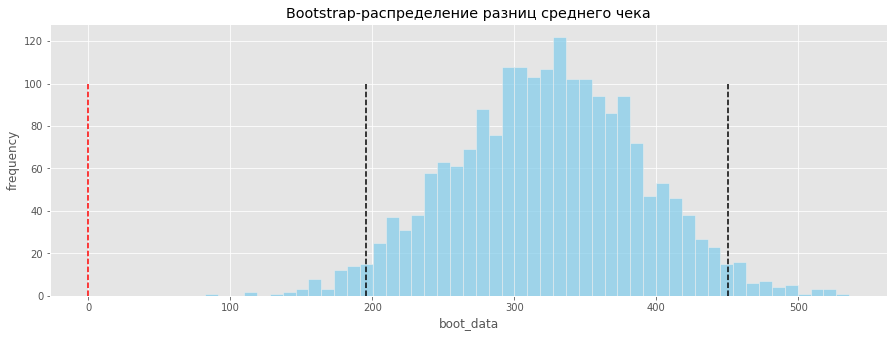

In [111]:
# проведем bootstrap-анализ
control = df_purchases[df_purchases['group'] == 'A'].revenue
test = df_purchases[df_purchases['group'] == 'B'].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test, control, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Как видно из полученной диаграммы, 0 не попадает в доверительный интервал, а pvalue < 0.05. Это означает, что различия среднего чека в тестовой и контрольной группе статистически значимы. 

Таким образом, и t-тест и bootstrap показали статистически значимые изменения среднего чека.

В результате, конверсия понизилась, а средний чек увеличился.
Посмотрим, как это повлияло на cредний доход с привлечённого пользователя: ARPU = конверсия * ARPPU:

In [102]:
metrics = avg_check.merge(df_CR, on=['group'])

In [114]:
metrics['ARPU'] = (metrics.revenue * (metrics.CR / 100)).round(2)

In [104]:
metrics

,group,revenue,user_id,payment,CR,ARPU
0,A,943.56,1538,78,5.07,47.84
1,B,1267.88,6803,314,4.62,58.58


ARPU повысился с 47.84 до 58.58 (на 22.4%)

--------------------------------------

Посмотрим как изменился средний чек в разрезе пользователей (по странам, платформам, полу) с помощью bootstrap:

pvalue = 0.029569313318502037


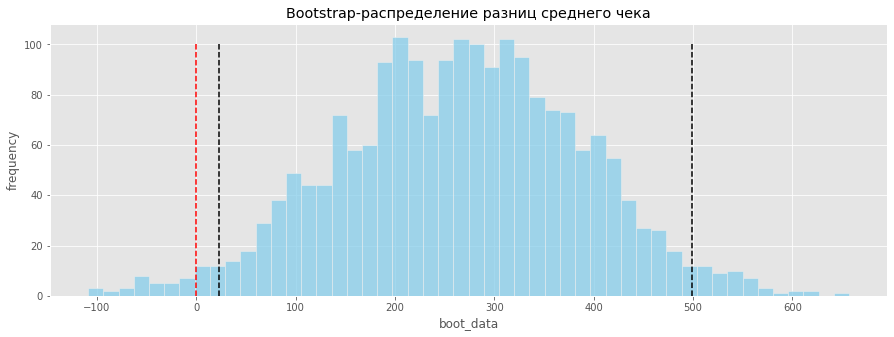

In [116]:
# для пользователей из Швеции
control_sweden = df_purchases[(df_purchases['group'] == 'A') & (df_purchases['country'] == "Sweden")].revenue 
test_sweden = df_purchases[(df_purchases['group'] == 'B') & (df_purchases['country'] == "Sweden")].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test_sweden, control_sweden, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Для Швеции - 0 не попал в доверительный интервал, значит, статистически значимая разница есть.

pvalue = 4.017253811832871e-07


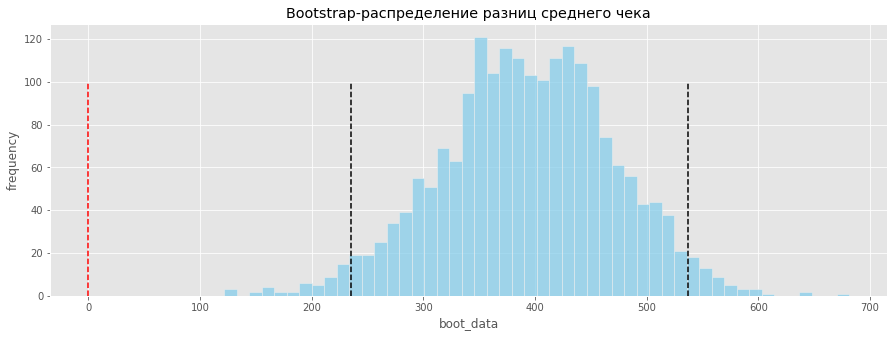

In [115]:
# для пользователей из России
control_russia = df_purchases[(df_purchases['group'] == 'A') & (df_purchases['country'] == "Russia")].revenue 
test_russia = df_purchases[(df_purchases['group'] == 'B') & (df_purchases['country'] == "Russia")].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test_russia, control_russia, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Для России - 0  не попал в доверительный интервал, значит, что разница статистически значима.

pvalue = 2.1225640091299166e-05


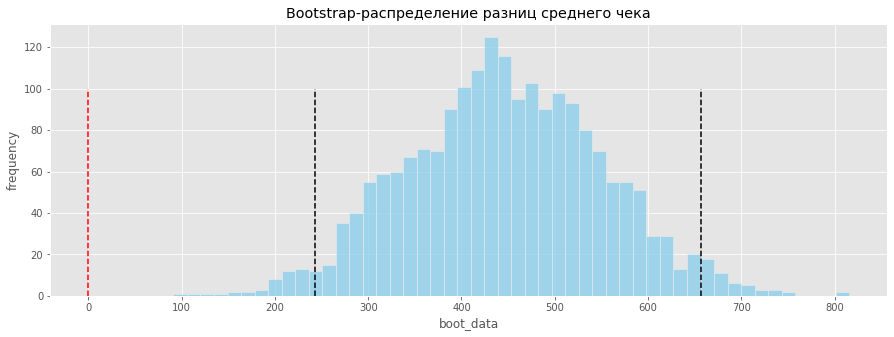

In [106]:
# для пользователей ios
control_ios = df_purchases[(df_purchases['group'] == 'A') & (df_purchases['platform'] == "ios")].revenue 
test_ios = df_purchases[(df_purchases['group'] == 'B') & (df_purchases['platform'] == "ios")].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test_ios, control_ios, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Для пользователей ios - 0  не попал в доверительный интервал, значит, что разница статистически значима.

pvalue = 0.019776964211512562


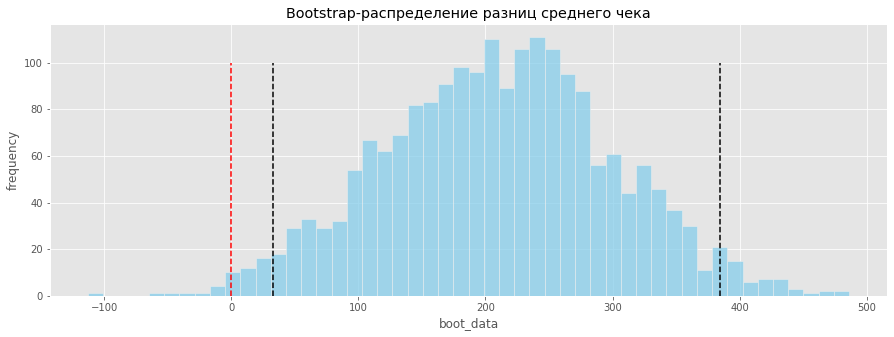

In [108]:
# для пользователей android
control_android = df_purchases[(df_purchases['group'] == 'A') & (df_purchases['platform'] == "android")].revenue 
test_android = df_purchases[(df_purchases['group'] == 'B') & (df_purchases['platform'] == "android")].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test_android, control_android, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Для пользователей android - 0 не попал в доверительный интервал, значит, что разница статистически значима.

pvalue = 0.11202719371796875


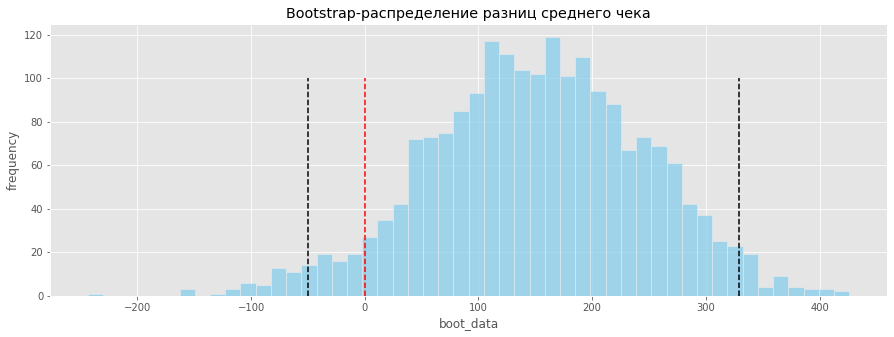

In [109]:
# для пользователей мужчин
control_male = df_purchases[(df_purchases['group'] == 'A') & (df_purchases['sex'] == "male")].revenue 
test_male = df_purchases[(df_purchases['group'] == 'B') & (df_purchases['sex'] == "male")].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test_male, control_male, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Для мужчин - 0 попал в доверительный интервал, значит, что статистически значимой разницы для тестовой и контрольных групп не обнаружено.

pvalue = 5.0646583498735765e-08


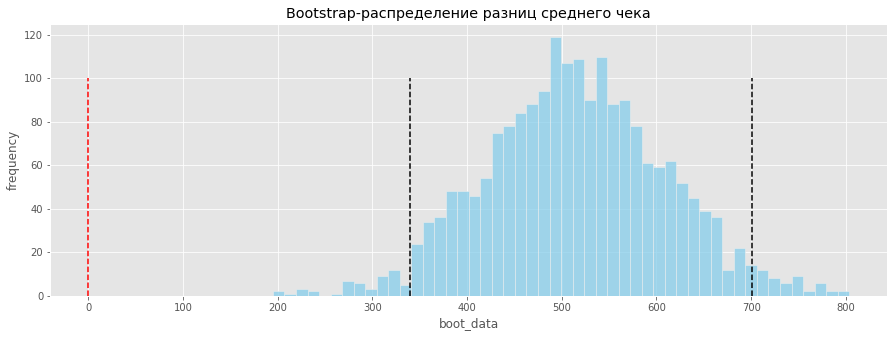

In [110]:
# для пользователей женщин
control_fem = df_purchases[(df_purchases['group'] == 'A') & (df_purchases['sex'] == "female")].revenue 
test_fem = df_purchases[(df_purchases['group'] == 'B') & (df_purchases['sex'] == "female")].revenue
# применяем bootstrap
bootstrap_result = get_bootstrap(test_fem, control_fem, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']
vizualization(boot_data, ci)

Для женщин - 0  не попал в доверительный интервал, значит, что разница статистически значима.

Таким образом, мы получили статистически значимую разницу для пользователей из обеих стран, обеих платформ и женщин.

## Выводы

В ходе анализа были получены следующие результаты: 

- В данных были найдены и исключены из анализа 149 пользователей, которые не посещали приложение во время эксперимента. 
- Данные в контрольной и тестовой группы несбалансированные по группам пользователей (странам, платформам), что говорит об ошибке в системе сплитования, следовательно, выводы по таким данным неоднозначны и полученные результаты могут объясняться этой ошибкой. 

***Конверсия:***

- конверсия в покупку **(СR)** *упала* с **5.07%** до **4.62%** (на **8%**);
- анализ по сегментам (странам, платформам, полу) также показало уменьшение конверсии на 4.7-13%

Конверсия была проанлизирована с помощью ХИ-квадрата, который **не выявил статистически значимых различий**. Однако стоит учитывать низкую мощность теста (0.58) и возможность наличия статистически значимых различий, которые тест не смог выявить. 

***Средний чек (ARPPU):***

- средний чек *увеличился* с **943** до **1267** рублей (на **34.3%**)
- анализ по сегментам показал увеличение среднего чека для пользователей из обеих стран, платформ, полов. 

Средний чек был проанализирован с помощью t-теста и и bootstrap, которые показали одинаковый результат - **разница статистически значима**. Анализ по сегментам был проведен с помощью bootstap. Для обеих стран (Россия, Швеция), платформ(ios, android) и женщин разница оказалась статистически значимой (для мужчин тест разницы не выявил). 

***ARPU:***

- ARPU *повысился* с **47.84** до **58.58** рублей (на **22.4%**)

В результате ARPU повысился, не смотря на уменьшении конверсии (уменьшение конверсии нивелировалось увеличением среднего чека).

**Заключение и рекомендации:**

В целом, новая модель оплаты показала **положительные результаты (увеличился доход)**, поэтому **можно выкатывать новую модель** на всех пользователей. 

Если есть возможность, стоит починить систему сплитования, чтобы выборки стали более сбалансированными, провести эксперимент заново, повысить длительность, чтобы набрать большее количество данных и повысить мощности тестов.


------

# Задание 2

**Условие:** одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

Дашборд был построен по имеющимся данным:

- active_users – информация о пользователях, которые посещали приложение во время эксперимента. 
- groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
- purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

Ссылка на дашборд:
https://public.tableau.com/app/profile/anastasia.prokhorova/viz/project4_16515876673680/Dashboard1